In [34]:
import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage.filters as flt
from struct import *
import datetime

In [35]:
header = np.dtype([('Headlen',np.int32),('NumFiles',np.int64),('PeanoCellHEALPixOrder',np.int64),('RayHEALPixOrder',np.int64),
          ('flag_defl',np.int64),('flag_phi',np.int64),
          ('pad',np.int8,216),('Headlen2',np.int32)])

ray = np.dtype([('nest',np.uint64),('ra','<f8'),('dec',np.double),
              ('A0',np.double),('A1',np.double),('A2',np.double),('A3',np.double),('phi',np.double)])

In [36]:
# set resolution
nside = 1024
npix = hp.nside2npix(nside);
step = 10

# initialise map and count arrays
count = np.zeros(npix, int)
m = np.zeros(npix, float)
phi = np.zeros(npix, float)

In [37]:
def process_rayfile(i):
    fname = 'raydata{0:04d}.{1:04d}'.format(plane,i)  
    #f = open('/lustre/scratch/astro/rb460/outputs/SHT_only_FullSky/'+ fname)
    f = open('/cosma6/data/dp004/dc-boot5/raytrace/SHT_FullSky_Born/'+ fname)
    headdata=np.fromfile(f, dtype=header,count=1)
    
    dummy = np.fromfile(f,np.dtype(np.int32),count=1)
    nrays = np.fromfile(f, np.dtype(np.int64),count=dummy[0]//8)
    dummy = np.fromfile(f,np.dtype(np.int32),count=1)
   
    dummy = np.fromfile(f,np.dtype(np.int32),count=1) 
    startrays = np.fromfile(f, np.dtype(np.int64),count=dummy[0]//8)
    dummy = np.fromfile(f,np.dtype(np.int32),count=1)
    
    print("NbundleCells * 4 = ",dummy[0])
    dummy = np.fromfile(f,np.dtype(np.int32),count=1)
    print("NumRaysInFile*rays=",dummy[0])
    print ('reading ray file {:02d}'.format(i))
    raydata = np.fromfile(f,dtype=ray, count = dummy[0]//56)
    f.close()
    #client.close()
    print ('done reading ray file {:02d}'.format(i))
    print ('analysing ray file {:02d}'.format(i), datetime.datetime.now().time())
    totrays = 0
    print ('size=', len(raydata))
    for r in raydata[0::step]:
        gamma = np.sqrt(((r[3]-r[6])/2)**2 + ((r[4]+r[5])/2)**2)  
        p = hp.ang2pix(nside, r[1], r[2], lonlat = True)
        count[p]+=1
        totrays += 1
        m[p]+= (gamma - m[p])/count[p]
        phi[p]+= (r[7] - phi[p])/count[p]
    print ('done analysing ray file {:02d}, total rays = {:d}'.format(i,totrays),datetime.datetime.now().time());

In [29]:
plane = 49
for i in np.arange(32):
    process_rayfile(i)
    print ('file {:2d} processed'.format(i))

NbundleCells * 4 =  6291456
NumRaysInFile*rays= 1610612736
reading ray file 00
done reading ray file 00
analysing ray file 00 20:37:06.432874
size= 25165824
done analysing ray file 00, total rays = 2516583 20:38:47.204479
file  0 processed
NbundleCells * 4 =  6291456
NumRaysInFile*rays= 1610612736
reading ray file 01
done reading ray file 01
analysing ray file 01 20:38:49.178886
size= 25165824
done analysing ray file 01, total rays = 2516583 20:40:32.011474
file  1 processed
NbundleCells * 4 =  6291456
NumRaysInFile*rays= 1610612736
reading ray file 02
done reading ray file 02
analysing ray file 02 20:40:33.826832
size= 25165824
done analysing ray file 02, total rays = 2516583 20:42:14.132466
file  2 processed
NbundleCells * 4 =  6291456
NumRaysInFile*rays= 1610612736
reading ray file 03
done reading ray file 03
analysing ray file 03 20:42:15.814716
size= 25165824
done analysing ray file 03, total rays = 2516583 20:43:55.309780
file  3 processed
NbundleCells * 4 =  6291456
NumRaysInFil

In [21]:
# fill empty pixels in map array with Healpix UNSEEN constant to hide empty pixels
n = np.asarray([hp.UNSEEN if x==0 else x for x in m])

In [30]:
print ('calculating spherical harmonics',datetime.datetime.now().time())
cl = hp.anafast(m)
print ('done calculating spherical harmonics',datetime.datetime.now().time())

calculating spherical harmonics 23:17:25.952329
done calculating spherical harmonics 23:17:30.500692


In [31]:
# write shear map and Cl to file
hp.write_map('maps/Shear_map_{}_{}'.format(nside, plane),m,overwrite=True)
hp.write_map('maps/Phi_map_{}_{}'.format(nside, plane),m,overwrite=True)
hp.write_cl('spectrum/Cl_spectrum_{}_{}'.format(nside, plane),cl,overwrite=True)

In [39]:
spec_path = '/cosma/home/dp004/dc-boot5/projects/PowerSpectrum/spectrum/'
#spec_path = '/cosma6/data/dp004/dc-boot5/Power Spectrum/Cl_Spectrum_Calclens/''
#map_path = '/cosma6/data/dp004/dc-boot5/Power Spectrum/maps/'
map_path = '/cosma6/data/dp004/dc-boot5/Power Spectrum/CALCLENS maps/'

cl = np.empty((50, 3072))
m = np.empty((50, npix))
phi = np.empty((50, npix))

# born, nside = 1024 planes
nside = 1024
npix = hp.nside2npix(nside);
planes = [9,12,15,17,18,21,27,35,45,48,49]
for plane in planes:
    map_fname = 'Shear_map_{0:04d}_{1:04d}'.format(nside, plane)
    spec_fname = 'Cl_spectrum_{0:04d}_{1:04d}'.format(nside,plane)
    phi_fname = 'Phi_map_{0:04d}_{1:04d}'.format(nside,plane)
    cl[plane] = hp.read_cl(spec_path+spec_fname)
    m[plane] = hp.read_map(map_path+map_fname)
    phi[plane] = hp.read_map(map_path+phi_fname)
    print('plane read', plane)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
plane read 9
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
plane read 12
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
plane read 15
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
plane read 17
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
plane read 18
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
plane read 21
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
plane read 27
NSIDE = 1024
ORDERING = RING in fit

In [40]:
# born, nside = 4096 planes
nside = 4096
npix = hp.nside2npix(nside);
cl2 = np.empty((50, 12288))
m2 = np.empty((50, npix))
phi2 = np.empty((50, npix))
planes = [26]
for plane in planes:
    map_fname = 'Shear_map_{0:04d}_{1:04d}'.format(nside, plane)
    spec_fname = 'Cl_spectrum_{0:04d}_{1:04d}'.format(nside,plane)
    phi_fname = 'Phi_map_{0:04d}_{1:04d}'.format(nside,plane)
    cl2[plane] = hp.read_cl(spec_path+spec_fname)
    m2[plane] = hp.read_map(map_path+map_fname)
    phi2[plane] = hp.read_map(map_path+phi_fname)
    print('plane read', plane) 

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
plane read 26


In [41]:
ell = np.arange(len(cl[1]))
ell2 = np.arange(len(cl2[26]))

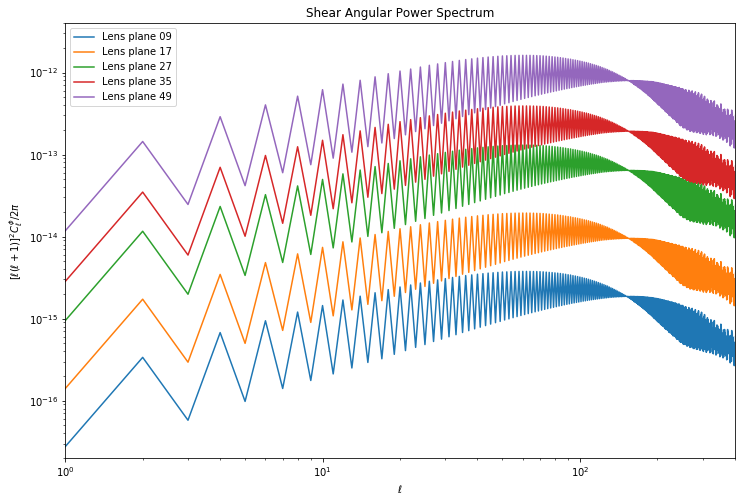

In [50]:
fig, ax = plt.subplots(1, 1,figsize=(12,8))
planes = [9,17,27,35,49] 
for plane in planes:
      ax.loglog(ell, (ell*(ell+1)/(2*np.pi)*cl[plane]), label='Lens plane {0:02d}'.format(plane))
#planes = [26] 
#for plane in planes:
      #ax.loglog(ell2, (ell2*(ell2+1)/(2*np.pi)*cl2[plane]), label='Lens plane {0:02d}'.format(plane))        
ax.set_xlabel('$\ell$')
ax.set_ylabel('$[\ell(\ell+1)]^2C_\ell^{\phi}/2\pi$')
ax.legend()
ax.set_xlim(1e0, 4e2)
ax.set_ylim(2e-17, 4e-12)
plt.title('Shear Angular Power Spectrum')
plt.show()
fig.savefig('shear_power_spec.pdf', format= 'pdf')

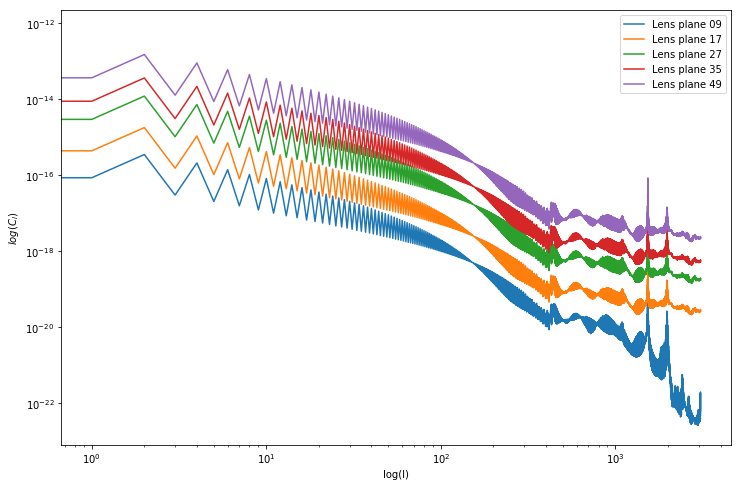

In [73]:
planes = [9,17,27,35,49]
fig, ax = plt.subplots(1, 1,figsize=(12,8))
for plane in planes:
      ax.loglog(ell, cl[plane], label='Lens plane {0:02d}'.format(plane))

ax.set_xlabel('log(l)')
ax.set_ylabel('$log(C_l)$')
ax.legend()
plt.show()

In [56]:
map_path = '/cosma6/data/dp004/dc-boot5/Power Spectrum/CALCLENS maps/'
nside = 1024
npix = hp.nside2npix(nside);
plane = 100
map_fname = 'Shear_map_{0:04d}_{1:04d}'.format(nside, plane)
m = hp.read_map(map_path+map_fname)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


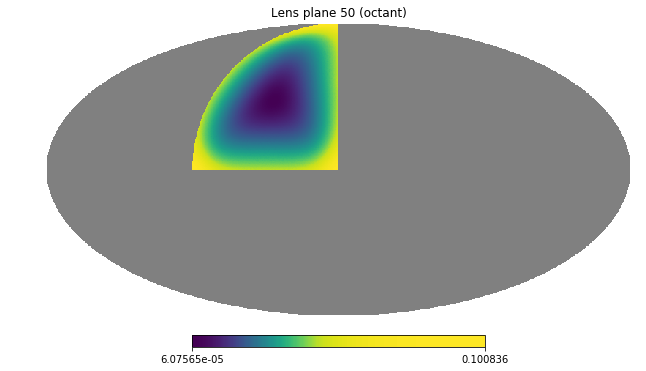

In [59]:
hp.mollview(m, norm='hist', title = 'Lens plane 50 (octant)')
plt.savefig('lens_plane_raytrace.pdf', format = 'pdf')

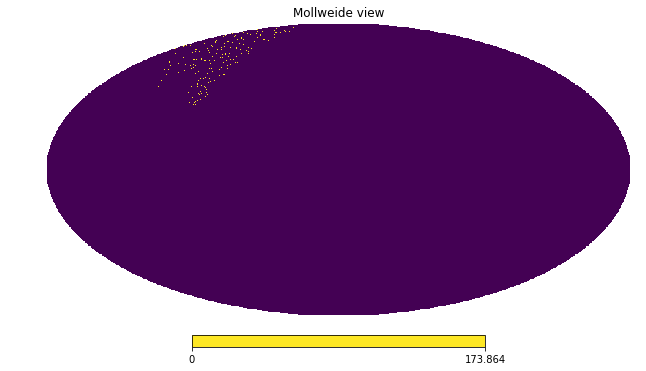

In [26]:
hp.mollview(phi, norm = 'hist')